<a href="https://colab.research.google.com/github/alimovabdulla/RUB_Oil_Relationship_Predictor/blob/main/USDRUB_Oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
# Kitabxanalarımızı İmport Edirik
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error


In [141]:
# Datasetlərimi oxuyuruq
usd_data = pd.read_excel('/content/usd_rate.xlsx')
oil_data = pd.read_excel('/content/brend_oil.xls', sheet_name=1, skiprows=2, names=['date','price'])

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# <span style="font-weight: bold; font-style: italic; color: green; text-shadow: 2px 2px 4px #000000;">EDA</span>


In [142]:
usd_data

,nominal,data,curs,cdx
0,1,2017-01-10,59.8961,Доллар США
1,1,2017-01-11,59.9533,Доллар США
2,1,2017-01-12,60.1614,Доллар США
3,1,2017-01-13,59.4978,Доллар США
4,1,2017-01-14,59.3700,Доллар США
...,...,...,...,...
979,1,2020-12-26,73.6921,Доллар США
980,1,2020-12-29,73.7175,Доллар США
981,1,2020-12-30,73.6567,Доллар США
982,1,2020-12-31,73.8757,Доллар США


In [208]:
oil_data

,date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9569,2025-02-04,76.58
9570,2025-02-05,74.71
9571,2025-02-06,74.54
9572,2025-02-07,74.68


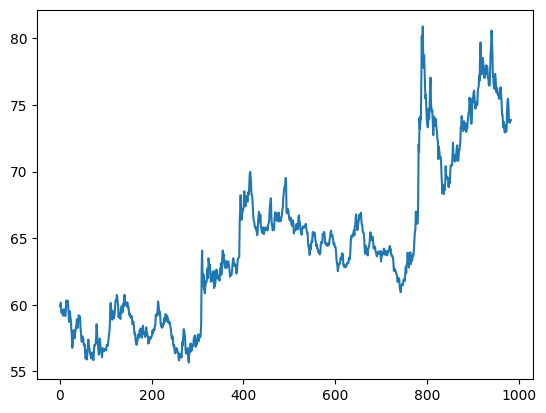

In [204]:
usd_data['curs'].plot()
plt.show()

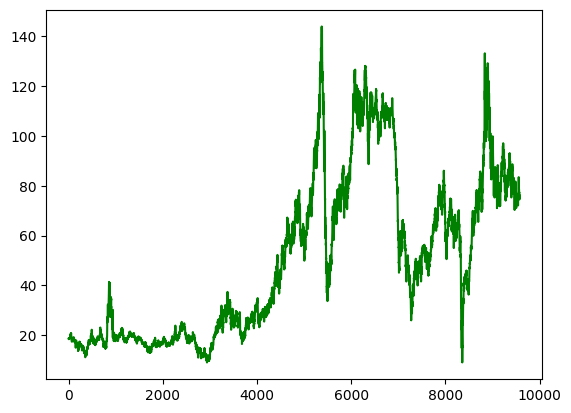

In [206]:
oil_data['price'].plot(c='g')
plt.show()

# <span style="font-weight: bold; font-style: italic; color: green; text-shadow: 2px 2px 4px #000000;">Data Preparation</span>


In [207]:
# "usd_data" datasetindəki "data" sütununu indeks kimi təyin edirik və
# "oil_data" datasetindəki "date" sütunu ilə indekslərə əsasən birləşdiririk
data = usd_data.set_index('data').join(oil_data.set_index('date'))

In [146]:
data = data.drop(['cdx','nominal'], axis=1) # lazımsız Kolonları silirik

In [147]:
data = data.ffill() # Boş dataları özlərinnən əvvəlki datalar ilə dəyişirik

In [148]:
data.reset_index(inplace=True)  # İndeksi sıfırlayır və "data" sütunu yenidən adi sütun olur.

In [149]:
data.isnull().sum()

,0
data,0
curs,0
price,0


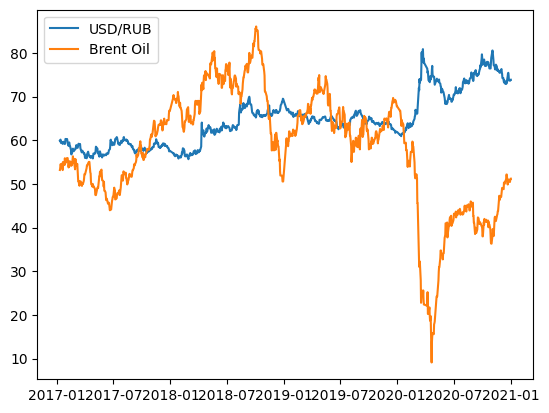

In [150]:
plt.plot(data['data'], data['curs'], label='USD/RUB')
plt.plot(data['data'], data['price'], label='Brent Oil')
plt.legend()
plt.show()

In [152]:
# 'data' sütunundan il, ay və həftənin gününü çıxarırıq və yeni sütunlara əlavə edirik.
# Bu, tarixlə bağlı daha ətraflı təhlillər aparmağa imkan verəcək.

data['year'] = data['data'].dt.year  # 'data' sütunundan ili çıxarır və 'year' sütununa yazır.
data['month'] = data['data'].dt.month # 'data' sütunundan ayı çıxarır və 'month' sütununa yazır.
data['weekday'] = data['data'].dt.weekday # 'data' sütunundan həftənin gününü (0-Bazar ertəsi, 6-Bazar) çıxarır və 'weekday' sütununa yazır.

In [153]:
past_day = 7 # Həftənin günləri

In [154]:
# Son keçmiş günlərin USD və neft qiymətlərini uyğun sütunlara əlavə edirik
for day in range(past_day):
  data[f'price_usd_back{day+1}'] = data['curs'].shift(day+1)
  data[f'price_oil_back{day+1}'] = data['price'].shift(day+1)


In [155]:
# Son 7 günün USD məzənnəsi və neft qiymətinin medianını hesablayırıq
data['curs_week'] = data['curs'].rolling(7).median()
data['price_week'] = data['price'].rolling(7).median()

In [156]:
# "year", "month" və "weekday" sütunlarını one-hot encoding üsulu ilə çevririk
data = pd.get_dummies(data, columns=['year','month','weekday'])

In [158]:
data.drop(['data', 'price'], axis=1, inplace=True) # Bu kolonlara artıg ehtiyac olmadıgına görə silirik

In [159]:
data.dropna(inplace=True) # Null/NaN Dəyərlər olan Sətirləri silirik

In [164]:
X = data.drop('curs', axis=1)
y = data['curs']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# <span style="font-weight: bold; font-style: italic; color: green; text-shadow: 2px 2px 4px #000000;">Model Building </span>


In [203]:
model = RandomForestRegressor()

In [194]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [183]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [188]:
grid = GridSearchCV(model,param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [189]:
best_model = grid.best_estimator_
best_params = grid.best_params_

In [192]:
print(best_params)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


In [190]:
rfpreds = best_model.predict(X_test)

In [191]:
print(f'MAX: {max_error(y_test, rfpreds)}')
print(f'MAE: {mean_absolute_error(y_test, rfpreds)}')
print(f'R2: {r2_score(y_test, rfpreds)}')
print(f'MSE: {mean_squared_error(y_test, rfpreds)}')

MAX: 2.406101087045812
MAE: 0.3602121678366643
R2: 0.9936241483816155
MSE: 0.24827442450652262


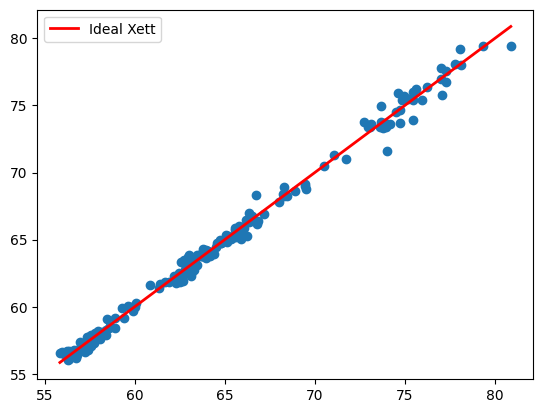

In [215]:
plt.scatter(y_test, preds)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], linewidth=2, color='r', label='Ideal Xett')
plt.legend()
plt.show()

fatal: not a git repository (or any of the parent directories): .git
